In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
boston = pd.read_csv('boston.csv')
boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


# 1. Split data: train - validate - test

In [3]:
# split train - validate - test
from sklearn.model_selection import train_test_split

feature = boston.drop(columns='medv')
target = boston[['medv']]

feature_boston_pretrain, feature_boston_test, target_boston_pretrain, target_boston_test = train_test_split(feature, 
                                                                                                            target, 
                                                                                                            test_size=0.20, 
                                                                                                            random_state=42)

feature_boston_train, feature_boston_validation, target_boston_train, target_boston_validation = train_test_split(feature_boston_pretrain, 
                                                                                                                  target_boston_pretrain, 
                                                                                                                  test_size=0.20, 
                                                                                                                  random_state=42)

# 2. Draw correlation plot on training data and perform feature selection on highly correlated features

In [4]:
# calculate VIF scores
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif 
from statsmodels.tools.tools import add_constant

X = add_constant(feature_boston_train)

vif_df = pd.DataFrame([vif(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns).reset_index()
vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,feature,vif_score
1,crim,1.750939
2,zn,2.473421
3,indus,3.741988
4,chas,1.110042
5,nox,4.585650
6,rm,1.972174
7,age,3.127443
8,dis,4.390458
9,rad,7.182410
10,tax,8.268145


There are several features with high VIF scores:
1. `indus`
2. `nox`
3. `age`
4. `dis`
5. `rad`
6. `tax`
7. `istat`

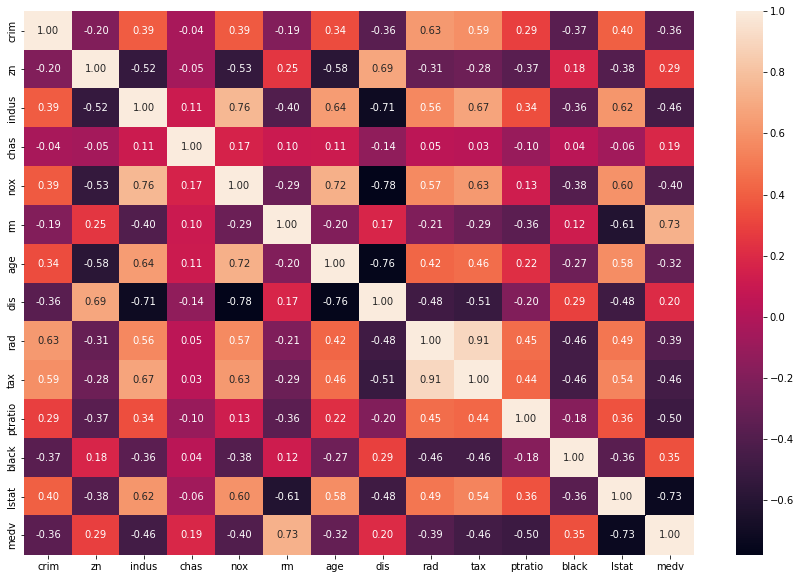

In [5]:
# heatmap correlation
boston_train = pd.concat([feature_boston_train, target_boston_train], axis=1)
corr = boston_train.corr()

plt.figure(figsize=(15,10))
sns.heatmap(corr, annot=True, fmt='.2f')
plt.show()

Note: Threshold: abs(corr) >= 0.80

I found that `rad` and `tax` are highly
correlated. Therefore, we need to drop:
* `rad`
* `tax`

In [6]:
# drop redundant feature
feature_boston_train = feature_boston_train.drop(columns=['rad','tax'])
feature_boston_validation = feature_boston_validation.drop(columns=['rad', 'tax'])
feature_boston_test = feature_boston_test.drop(columns=['rad', 'tax'])

In [7]:
# Recheck VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif 
from statsmodels.tools.tools import add_constant

X = add_constant(feature_boston_train)

vif_df = pd.DataFrame([vif(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns).reset_index()
vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,feature,vif_score
1,crim,1.404723
2,zn,2.253252
3,indus,3.214656
4,chas,1.097597
5,nox,4.118454
6,rm,1.908463
7,age,3.085304
8,dis,4.382486
9,ptratio,1.526414
10,black,1.323257


# 3. Fit models on training data (lambdas = [0.01, 0.1, 1, 10])

## a. Ridge regression

In [8]:
from sklearn.linear_model import Ridge

# train the model
X_boston_train = feature_boston_train.to_numpy()
y_boston_train = target_boston_train.to_numpy()
y_boston_train = y_boston_train.reshape(len(y_boston_train),)

# define the model
ridge_reg_pointzeroone = Ridge(alpha=0.01, random_state=42)
ridge_reg_pointone = Ridge(alpha=0.1, random_state=42)
ridge_reg_one = Ridge(alpha=1, random_state=42)
ridge_reg_ten = Ridge(alpha=10, random_state=42)

# fit the model (training)
ridge_reg_pointzeroone.fit(X_boston_train, y_boston_train)
ridge_reg_pointone.fit(X_boston_train, y_boston_train)
ridge_reg_one.fit(X_boston_train, y_boston_train)
ridge_reg_ten.fit(X_boston_train, y_boston_train)

Ridge(alpha=10, random_state=42)

## b. LASSO

In [9]:
from sklearn.linear_model import Lasso

# train the model
X_boston_train = feature_boston_train.to_numpy()
y_boston_train = target_boston_train.to_numpy()
y_boston_train = y_boston_train.reshape(len(y_boston_train),)

# define the model
lasso_reg_pointzeroone = Lasso(alpha=0.01, random_state=42)
lasso_reg_pointone = Lasso(alpha=0.1, random_state=42)
lasso_reg_one = Lasso(alpha=1, random_state=42)
lasso_reg_ten = Lasso(alpha=10, random_state=42)

# fit the model (training)
lasso_reg_pointzeroone.fit(X_boston_train, y_boston_train)
lasso_reg_pointone.fit(X_boston_train, y_boston_train)
lasso_reg_one.fit(X_boston_train, y_boston_train)
lasso_reg_ten.fit(X_boston_train, y_boston_train)

Lasso(alpha=10, random_state=42)

# 4. Choose the best lambda from the validation set

## a. Use RMSE as metric

In [10]:
# Ridge Regression
from sklearn.metrics import mean_squared_error

X_boston_validation = feature_boston_validation.to_numpy()
y_boston_validation = target_boston_validation.to_numpy()
y_boston_validation = y_boston_validation.reshape(len(y_boston_validation),)

alphas = [0.01, 0.1, 1., 10]
models = [ridge_reg_pointzeroone,
          ridge_reg_pointone,
          ridge_reg_one,
          ridge_reg_ten]

for model, alpha in zip(models, alphas):
    y_predict_validation = model.predict(X_boston_validation)
    rmse = np.sqrt(mean_squared_error(y_boston_validation,y_predict_validation))
    print(f'RMSE of Ridge regression model with alpha = {alpha} is {rmse}')

RMSE of Ridge regression model with alpha = 0.01 is 4.962234082671707
RMSE of Ridge regression model with alpha = 0.1 is 4.950661805765886
RMSE of Ridge regression model with alpha = 1.0 is 4.909045042614708
RMSE of Ridge regression model with alpha = 10 is 4.867167076950583


The best lambda is 10 `ridge_reg_ten`

In [11]:
# LASSO
from sklearn.metrics import mean_squared_error

X_boston_validation = feature_boston_validation.to_numpy()
y_boston_validation = target_boston_validation.to_numpy()
y_boston_validation = y_boston_validation.reshape(len(y_boston_validation),)

alphas = [0.01, 0.1, 1., 10]
models = [lasso_reg_pointzeroone,
          lasso_reg_pointone,
          lasso_reg_one,
          lasso_reg_ten]

for model, alpha in zip(models, alphas):
    y_predict_validation = model.predict(X_boston_validation)
    rmse = np.sqrt(mean_squared_error(y_boston_validation,y_predict_validation))
    print(f'RMSE of Lasso regression model with alpha = {alpha} is {rmse}')

RMSE of Lasso regression model with alpha = 0.01 is 4.934493563284168
RMSE of Lasso regression model with alpha = 0.1 is 4.904075071284979
RMSE of Lasso regression model with alpha = 1.0 is 4.845769009470302
RMSE of Lasso regression model with alpha = 10 is 5.4366365235863565


The best lambda is 1. `ridge_reg_one`

## b. Interpret a sample of the coefficients of the best model

In [12]:
# Ridge Regression
ridge_best = ridge_reg_ten

coef_df = pd.DataFrame({
    'feature':['intercept'] + feature_boston_train.columns.tolist(),
    'coefficient':[ridge_best.intercept_] + list(ridge_best.coef_)
})

coef_df

,feature,coefficient
0,intercept,15.150035
1,crim,-0.081692
2,zn,0.030016
3,indus,-0.086739
4,chas,1.946433
5,nox,-1.668543
6,rm,4.759384
7,age,-0.010993
8,dis,-1.236508
9,ptratio,-0.731620


coeff interpretation:
* An increase of 1 point in `crim` (Criminal Rate), while the other features are kept fixed, is associated with an decrease of 0.081 point in `medv` (Housing Price)
* An increase of 1 point in `zn` (Residential land zoned proportion), while the other features are kept fixed, is associated with an increase of 0.030 point in `medv` (Housing Price)
* An increase of 1 point in `indus` (Non-retail business acres proportion), while the other features are kept fixed, is associated with an decrease of 0.086 point in `medv` (Housing Price)
* An increase of 1 point in `chas` (Is bounds with river), while the other features are kept fixed, is associated with an increase of 1.946 point in `medv` (Housing Price)
* An increase of 1 point in `nox` (Nitrogen oxides concentration), while the other features are kept fixed, is associated with an decrease of 1.668 point in `medv` (Housing Price)
* An increase of 1 point in `rm` (Number rooms average), while the other features are kept fixed, is associated with an increase of 4.759 point in `medv` (Housing Price)
* An increase of 1 point in `age` (Owner age proportion), while the other features are kept fixed, is associated with an decrease of 0.010 point in `medv` (Housing Price)
* An increase of 1 point in `dis` (Weighted distance to cities), while the other features are kept fixed, is associated with an decrease of 1.236 point in `medv` (Housing Price)
* An increase of 1 point in `ptratio` (Pupil-teacher ratio), while the other features are kept fixed, is associated with an decrease of 0.731 point in `medv` (Housing Price)
* An increase of 1 point in `black` (Black proportion), while the other features are kept fixed, is associated with an increase of 0.013 point in
* An increase of 1 point in `lstat` (Percent lower status), while the other features are kept fixed, is associated with an decrease of 0.528 point in 

In [13]:
# LASSO
lasso_best = lasso_reg_one

coef_df = pd.DataFrame({
    'feature':['intercept'] + feature_boston_train.columns.tolist(),
    'coefficient':[lasso_best.intercept_] + list(lasso_best.coef_)
})

coef_df

,feature,coefficient
0,intercept,25.859306
1,crim,-0.056676
2,zn,0.020648
3,indus,-0.028455
4,chas,0.000000
5,nox,-0.000000
6,rm,2.465867
7,age,0.022761
8,dis,-0.557911
9,ptratio,-0.717385


coeff interpretation:
* An increase of 1 point in `crim` (Criminal Rate), while the other features are kept fixed, is associated with an decrease of 0.056 point in `medv` (Housing Price)
* An increase of 1 point in `zn` (Residential land zoned proportion), while the other features are kept fixed, is associated with an increase of 0.020 point in `medv` (Housing Price)
* An increase of 1 point in `indus` (Non-retail business acres proportion), while the other features are kept fixed, is associated with an decrease of 0.028 point in `medv` (Housing Price)
* An increase of 1 point in `chas` (Is bounds with river), while the other features are kept fixed, isn't associated with `medv` (Housing Price)
* An increase of 1 point in `nox` (Nitrogen oxides concentration), while the other features are kept fixed, isn't associated with `medv` (Housing Price)
* An increase of 1 point in `rm` (Number rooms average), while the other features are kept fixed, is associated with an increase of 2.465 point in `medv` (Housing Price)
* An increase of 1 point in `age` (Owner age proportion), while the other features are kept fixed, is associated with an increase of 0.022 point in `medv` (Housing Price)
* An increase of 1 point in `dis` (Weighted distance to cities), while the other features are kept fixed, is associated with an decrease of 0.557 point in `medv` (Housing Price)
* An increase of 1 point in `ptratio` (Pupil-teacher ratio), while the other features are kept fixed, is associated with an decrease of 0.717 point in `medv` (Housing Price)
* An increase of 1 point in `black` (Black proportion), while the other features are kept fixed, is associated with an increase of 0.012 point in
* An increase of 1 point in `lstat` (Percent lower status), while the other features are kept fixed, is associated with an decrease of 0.719 point in 

# 5. Evaluate the best models on the test data (+ interpretation)

## a. Ridge Regression

In [14]:
from sklearn.metrics import r2_score

y_predict_train = ridge_best.predict(X_boston_train)

print('R-squared for training data is {}'.format(r2_score(y_predict_train, y_boston_train)))

R-squared for training data is 0.653505673552075


Interpretation: 65.35% of variability of `medv` is successfully explained using all the features in the model.

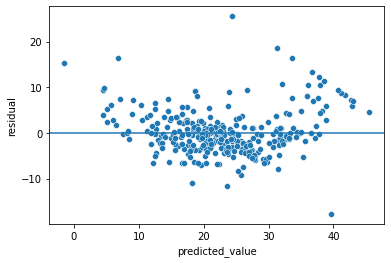

In [15]:
# calculate residuals
residual = y_boston_train - y_predict_train

# prepare dataframe
# 1 predictor --> predictor VS residual
df_resid = pd.DataFrame({
    'predicted_value': y_predict_train,
    'residual': residual
})

# residual plot
sns.scatterplot(data=df_resid, x="predicted_value", y="residual")
plt.axhline(0)
plt.show()

Assumptions to check via residual plot:
* Linear relationship (yes)
* Constant variance (no)
* Independent observations (no)

## Training Error

In [16]:
# prepare prediction result on train data
y_predict_train = ridge_best.predict(X_boston_train)

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for training data is {}'.format(np.sqrt(mean_squared_error(y_predict_train, y_boston_train))))
print('MAE for training data is {}'.format(mean_absolute_error(y_predict_train, y_boston_train)))
print('MAPE for training data is {}'.format(mean_absolute_percentage_error(y_predict_train, y_boston_train)))

RMSE for training data is 4.782228475318233
MAE for training data is 3.389406834761317
MAPE for training data is 0.20893180788325846


RMSE = 4.782
* The standard deviation of prediction errors is 4.782
* i.e. from the regression line, the residuals mostly deviate between +- 4.782

MAE = 3.389
* On average, our prediction deviates the true `medv` by 3.389

MAPE = 0.2089 = 20.89%
* Moreover, this 3.389 is equivalent to 20.89% deviation relative to the true `medv`

## Testing Error

In [17]:
# prepare prediction result on test data
X_boston_test = feature_boston_test.to_numpy()
y_predict_test = ridge_best.predict(X_boston_test)

# ground truth target
y_boston_test = target_boston_test.to_numpy()
y_boston_test = y_boston_test.reshape(len(y_boston_test),)

In [18]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for testing data is {}'.format(np.sqrt(mean_squared_error(y_predict_test, y_boston_test))))
print('MAE for testing data is {}'.format(mean_absolute_error(y_predict_test, y_boston_test)))
print('MAPE for testing data is {}'.format(mean_absolute_percentage_error(y_predict_test, y_boston_test)))

RMSE for testing data is 5.1603544653640565
MAE for testing data is 3.254717665955977
MAPE for testing data is 0.25922815354901996


RMSE = 5.160
* The standard deviation of prediction errors is 5.160
* i.e. from the regression line, the residuals mostly deviate between +- 5.160

MAE = 3.255
* On average, our prediction deviates the true `medv` by 3.255

MAPE = 0.2592 = 25.92%
* Moreover, this 3.255 is equivalent to 25.92% deviation relative to the true `medv`

## b. LASSO

In [19]:
from sklearn.metrics import r2_score

y_predict_train = lasso_best.predict(X_boston_train)

print('R-squared for training data is {}'.format(r2_score(y_predict_train, y_boston_train)))

R-squared for training data is 0.5116154939145027


Interpretation: 51.16% of variability of `medv` is successfully explained using all the features in the model.

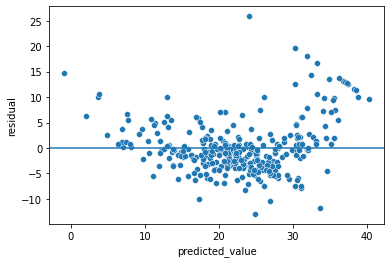

In [20]:
# calculate residuals
residual = y_boston_train - y_predict_train

# prepare dataframe
# 1 predictor --> predictor VS residual
df_resid = pd.DataFrame({
    'predicted_value': y_predict_train,
    'residual': residual
})

# residual plot
sns.scatterplot(data=df_resid, x="predicted_value", y="residual")
plt.axhline(0)
plt.show()

Assumptions to check via residual plot:
* Linear relationship (yes)
* Constant variance (no)
* Independent observations (no)

## Training Error

In [21]:
# prepare prediction result on training data
y_predict_train = lasso_best.predict(X_boston_train)

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for training data is {}'.format(np.sqrt(mean_squared_error(y_predict_train, y_boston_train))))
print('MAE for training data is {}'.format(mean_absolute_error(y_predict_train, y_boston_train)))
print('MAPE for training data is {}'.format(mean_absolute_percentage_error(y_predict_train, y_boston_train)))

RMSE for training data is 5.175294931416954
MAE for training data is 3.697337156294457
MAPE for training data is 0.23804956492884471


RMSE = 5.175
* The standard deviation of prediction errors is 5.175
* i.e. from the regression line, the residuals mostly deviate between +- 5.175

MAE = 3.697
* On average, our prediction deviates the true `medv` by 3.697

MAPE = 0.2380 = 23.80%
* Moreover, this 3.697 is equivalent to 23.80% deviation relative to the true `medv`

## Testing Error

In [22]:
# prepare prediction result on test data
X_boston_test = feature_boston_test.to_numpy()
y_predict_test = lasso_best.predict(X_boston_test)

# ground truth target
y_boston_test = target_boston_test.to_numpy()
y_boston_test = y_boston_test.reshape(len(y_boston_test),)

In [23]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for testing data is {}'.format(np.sqrt(mean_squared_error(y_predict_test, y_boston_test))))
print('MAE for testing data is {}'.format(mean_absolute_error(y_predict_test, y_boston_test)))
print('MAPE for testing data is {}'.format(mean_absolute_percentage_error(y_predict_test, y_boston_test)))

RMSE for testing data is 5.158262252813465
MAE for testing data is 3.446024713577441
MAPE for testing data is 0.2890801712598659


RMSE = 5.158
* The standard deviation of prediction errors is 5.158
* i.e. from the regression line, the residuals mostly deviate between +- 5.158

MAE = 3.446
* On average, our prediction deviates the true `medv` by 3.446

MAPE = 0.2890 = 28.90%
* Moreover, this 3.446 is equivalent to 28.90% deviation relative to the true `medv`